In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.io.wavfile as wav
from speechpy.feature import mfcc
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow import keras
from keras.utils import np_utils
from sklearn.utils.multiclass import unique_labels

Using TensorFlow backend.


**Load the data set**

In [2]:
FILEPATH_SPEECH= 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\dataset\\Audio_Song_Actors_01-24\\'
dir_list_speech = os.listdir(FILEPATH_SPEECH)

In [3]:
FILEPATH_SONG = 'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\dataset\\Audio_Song_Actors_01-24\\'
dir_list_song = os.listdir(FILEPATH_SONG)

In [4]:
#get the paths
dirts = []
filepath_delete = True
for root, dirt,file in os.walk(FILEPATH_SPEECH):
    if filepath_delete == True:
        print(root, "hahaha")
        filepath_delete = False
    else:
        dirts.append(root)     

C:\Users\ZhaoY\Downloads\DL_Project\dataset\Audio_Song_Actors_01-24\ hahaha


In [5]:
filepath_delete = True
for root, dirt,file in os.walk(FILEPATH_SONG):
    if filepath_delete == True:
        print(root, "hahaha")
        filepath_delete = False
    else:
        dirts.append(root)

C:\Users\ZhaoY\Downloads\DL_Project\dataset\Audio_Song_Actors_01-24\ hahaha


In [6]:
#get the files in every path
files = []
for dirt in dirts:
    for root, dt, file in os.walk(dirt):
        for fl in file:
            files.append(os.path.join(dirt,fl))  

In [7]:
files[1]

'C:\\Users\\ZhaoY\\Downloads\\DL_Project\\dataset\\Audio_Song_Actors_01-24\\Actor_01\\03-02-01-01-01-02-01.wav'

In [8]:
filename = []
Actor = []
for file in files:
    filename.append(file.split('\\')[-1])
    Actor.append(file.split('\\')[-2])

In [9]:
filename[0]

'03-02-01-01-01-01-01.wav'

In [10]:
Actor[-1]

'Actor_24'

In [11]:
Modality = []
Vocal_channel = []
Emotion = []
Emotional_intensity = []
Statement = []
Repetition = []

for name in filename:
    Modality.append(name.split('-')[0])
    Vocal_channel.append(name.split('-')[1])
    Emotion.append(int(name.split('-')[2])-1)
    Emotional_intensity.append(name.split('-')[3])
    Statement.append(name.split('-')[4])
    Repetition.append(name.split('-')[5])

In [12]:
df = pd.DataFrame({'files': files, 
                   'modalities': Modality,
                   'vocal_channels': Vocal_channel, 
                   'emotions': Emotion,
                   'emotional_intensities': Emotional_intensity,
                   'statements': Statement,
                   'repetitiona': Repetition})

In [13]:
df.head(1)

,files,modalities,vocal_channels,emotions,emotional_intensities,statements,repetitiona
0,C:\Users\ZhaoY\Downloads\DL_Project\dataset\Au...,03,02,0,01,01,01


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024 entries, 0 to 2023
Data columns (total 7 columns):
files                    2024 non-null object
modalities               2024 non-null object
vocal_channels           2024 non-null object
emotions                 2024 non-null int64
emotional_intensities    2024 non-null object
statements               2024 non-null object
repetitiona              2024 non-null object
dtypes: int64(1), object(6)
memory usage: 110.8+ KB


In [15]:
df.emotions.value_counts()

5    368
4    368
3    368
2    368
1    368
0    184
Name: emotions, dtype: int64

(array([184.,   0., 368.,   0., 368.,   0., 368.,   0., 368., 368.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

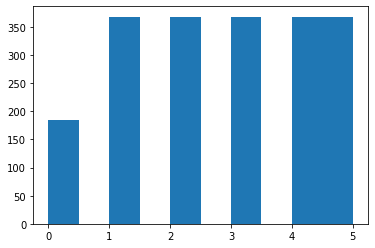

In [16]:
plt.hist(df.emotions)

In [17]:
print(len(files))

2024


In [18]:
mean_signal_length = 0
signals = []
for fname in files:
    signal, fs = librosa.load(fname, sr=16000, mono=True)
    mean_signal_length += len(signal)
    signals.append(signal)
mean_signal_length = mean_signal_length/(len(files))

In [19]:
mean_signal_length = int(mean_signal_length) 
print(mean_signal_length)

74387


In [20]:
def get_feature_vector_from_mfcc(signal, mean_signal_length: int, flatten: bool) -> np.ndarray:
    """
    Make feature vector from MFCC for the given wav file.

    Args:
        file_path (str): path to the .wav file that needs to be read.
        flatten (bool) : Boolean indicating whether to flatten mfcc obtained.
        mfcc_len (int): Number of cepestral co efficients to be consider.

    Returns:
        numpy.ndarray: feature vector of the wav file made from mfcc.
    """
    #fs, signal = wav.read(file_path)
    #signal, fs = librosa.load(file_path, sr=16000, mono=True)
    s_len = len(signal)

    # pad the signals to have same size if lesser than required
    # else slice them    
    
    if s_len < mean_signal_length:
        pad_len = mean_signal_length - s_len
        pad_rem = pad_len % 2
        pad_len //= 2
        signal = np.pad(signal, (pad_len, pad_len + pad_rem),
                        'constant', constant_values=0)
    else:
        pad_len = s_len - mean_signal_length
        pad_len //= 2
        signal = signal[pad_len:pad_len + mean_signal_length]
        
    # sample/frame = mean_signal_length*frame_length
    mel_coefficients = mfcc(signal, fs, frame_length=0.048, frame_stride=0.024, num_filters=30, num_cepstral=30, low_frequency=60, high_frequency=7600)
    if flatten:
        # Flatten the data
        mel_coefficients = np.ravel(mel_coefficients)
    return mel_coefficients

In [21]:
features = []
for signal in signals:
    features.append(get_feature_vector_from_mfcc(signal, mean_signal_length, flatten=False))

In [22]:
features[0]

array([[-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-36.04365339,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

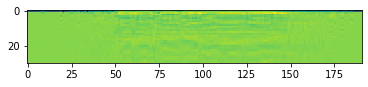

In [23]:
plt.imshow(features[0].T)

In [24]:
#need to stack these features, so need to add one demenssion
features = np.vstack([feature[np.newaxis, :, :] for feature in features])
features.shape

(2024, 191, 30)

In [25]:
np.unique(Emotion)

array([0, 1, 2, 3, 4, 5])

In [26]:
#one hot code, it is classification not logistic regression, so change numbers to one hot code
labels = np_utils.to_categorical(Emotion)

In [27]:
labels.shape

(2024, 6)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [29]:
def build_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.LSTM(128, input_shape=(input_shape[0], input_shape[1])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(16, activation='tanh'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [30]:
model = build_model(input_shape=(features.shape[1], features.shape[2]), num_classes=labels.shape[1])

In [31]:
labels.shape

(2024, 6)

In [32]:
features.shape

(2024, 191, 30)

In [33]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=0.2,
                               patience=5,
                               min_lr=1e-6,
                               verbose=1)

In [34]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=34, validation_data=(x_test, y_test), callbacks=[lr_reducer])

Train on 1619 samples, validate on 405 samples
Epoch 1/34
1619/1619 [==============================] - 14s 9ms/sample - loss: 1.8006 - accuracy: 0.2489 - val_loss: 1.7262 - val_accuracy: 0.2617
Epoch 2/34
1619/1619 [==============================] - 11s 7ms/sample - loss: 1.6377 - accuracy: 0.3187 - val_loss: 1.6105 - val_accuracy: 0.3309
Epoch 3/34
1619/1619 [==============================] - 12s 7ms/sample - loss: 1.5085 - accuracy: 0.3706 - val_loss: 1.4760 - val_accuracy: 0.4000
Epoch 4/34
1619/1619 [==============================] - 11s 7ms/sample - loss: 1.4241 - accuracy: 0.4120 - val_loss: 1.4294 - val_accuracy: 0.4099
Epoch 5/34
1619/1619 [==============================] - 11s 7ms/sample - loss: 1.3486 - accuracy: 0.4256 - val_loss: 1.2312 - val_accuracy: 0.4617
Epoch 6/34
1619/1619 [==============================] - 11s 7ms/sample - loss: 1.2295 - accuracy: 0.4873 - val_loss: 1.2078 - val_accuracy: 0.4790
Epoch 7/34
1619/1619 [==============================] - 11s 7ms/sample 

In [35]:
def draw_hist(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.figure(figsize=(8, 4.5))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # clear figure
    acc_values = acc
    val_acc_values = val_acc

    plt.figure(figsize=(8, 4.5))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    print('unique labels:', unique_labels(y_true, y_pred))
    classes = np.array(classes)[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    fig.set_figheight(9)
    fig.set_figwidth(9)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

0.2587634240035658 0.9259259
Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        33
           1       0.86      0.98      0.92        64
           2       0.95      0.90      0.92        78
           3       1.00      0.89      0.94        79
           4       0.94      0.97      0.96        69
           5       0.90      0.93      0.92        82

    accuracy                           0.93       405
   macro avg       0.92      0.92      0.92       405
weighted avg       0.93      0.93      0.93       405

Confusion matrix: 
[[29  2  0  0  0  2]
 [ 0 63  1  0  0  0]
 [ 2  2 70  0  2  2]
 [ 0  6  1 70  0  2]
 [ 0  0  0  0 67  2]
 [ 2  0  2  0  2 76]]


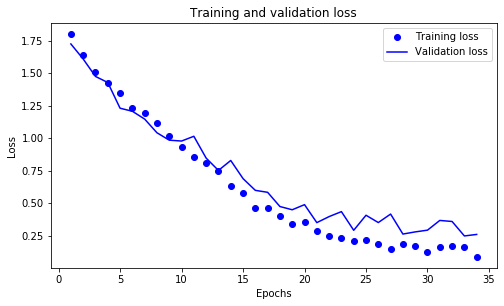

<Figure size 432x288 with 0 Axes>

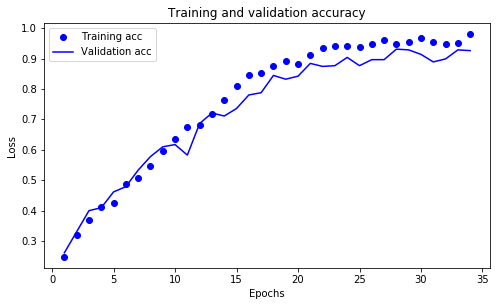

unique labels: [0 1 2 3 4 5]
Normalized confusion matrix


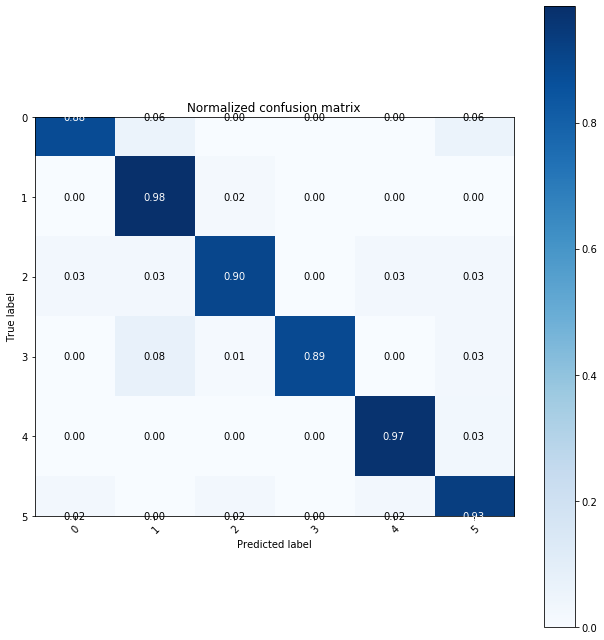

In [37]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(test_loss, test_acc)
pred_labels = model.predict(x_test)
print('Classification report: ')
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_labels, axis=1)))
print('Confusion matrix: ')
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_labels, axis=1)))
draw_hist(hist) 
plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_labels, axis=1), normalize=True, classes=[str(i) for i in range(10)])